In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import pysam
from pyBioInfo.IO.File import GtfFile, GtfTranscriptBuilder, Alignment, FastaFile

# Cell-type-specific expressed isoforms

In [2]:
cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
array = []
for ct in cts:
    path = "results/halflife/%s.transcript_based.transcript_id.annotated.tsv" % ct
    d = pd.read_csv(path, sep="\t", index_col=0)
    d.index = d["TranscriptName"]
    d.columns = ["%s.%s" % (c, ct) for c in d.columns]
    array.append(d)
dat = pd.concat(array, axis=1)
dat.index.name = "TranscriptName"

genes = []
for x in dat.index:
    if "novel" in x:
        genes.append(x[:x.find("novel") - 1])
    else:
        genes.append(x[:-4])
dat["GeneName"] = genes

data = {gene: tmp for gene, tmp in dat.groupby(by="GeneName")}

In [7]:
data_matrix = dict()
for ct in cts:
    path = "results/matrix/%s_transcripts.transcript_name.total.tsv" % ct
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d.divide(d.sum(axis=0), axis=1) * 10000
    data_matrix[ct] = d
all_matrix = pd.concat(data_matrix.values(), axis=1).fillna(0)
for ct in cts:
    data_matrix[ct] = all_matrix[data_matrix[ct].columns]

FileNotFoundError: [Errno 2] No such file or directory: 'results/matrix/ICM-1_transcripts.transcript_name.total.tsv'

In [4]:
isoform_specific_genes = list()
for gene, d in data.items():
    if len(d) < 2:
        continue
    d = d[["Total.%s" % ct for ct in cts]].fillna(0)
    for ct1 in cts:
        for ct2 in cts:
            if ct1 >= ct2:
                continue
            cs1 = d["Total.%s" % ct1].values
            cs2 = d["Total.%s" % ct2].values
            cutoff = 40
            if sum(cs1) > cutoff and sum(cs2) > cutoff:
                rs1 = cs1 / sum(cs1)
                rs2 = cs2 / sum(cs2)
                diffs = rs1 - rs2
                if any(np.abs(diffs) > 0.4):
                    isoform_specific_genes.append(gene)

In [5]:
isoform_specific_genes = list(sorted(set(isoform_specific_genes)))
isoform_specific_genes

['1810026B05Rik',
 '2610318N02Rik',
 'Actn1',
 'Adprh',
 'C130073F10Rik',
 'Caprin1',
 'Ccdc12',
 'Ccdc42',
 'Cdk2ap1',
 'Cndp2',
 'Crb3',
 'Folr1',
 'H3f3b',
 'Lmna',
 'Pdlim7',
 'Pemt',
 'Prrc1',
 'Pstk',
 'Rpl41',
 'Rpl9',
 'Snhg5',
 'Snrpc',
 'Srebf2',
 'Tpm1',
 'Ugp2',
 'Vma21']

1810026B05Rik


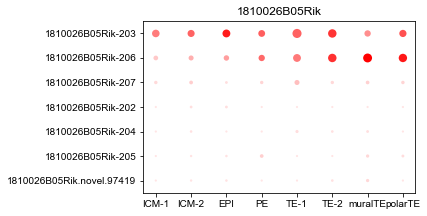

2610318N02Rik


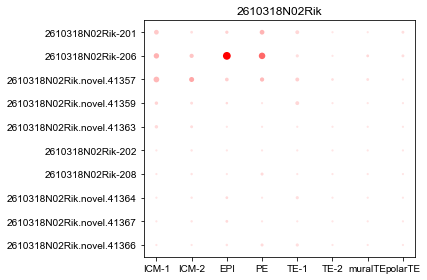

Actn1


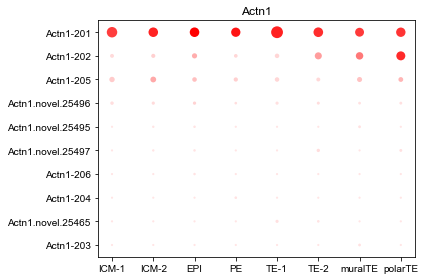

Adprh


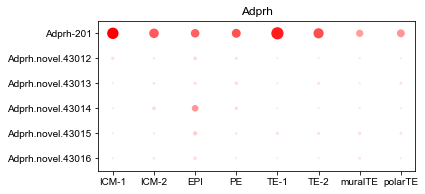

C130073F10Rik


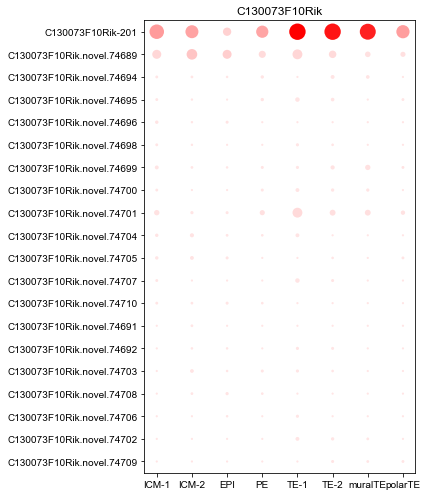

Caprin1


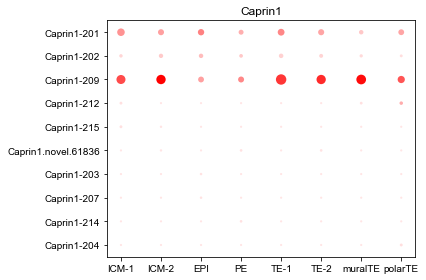

Ccdc12


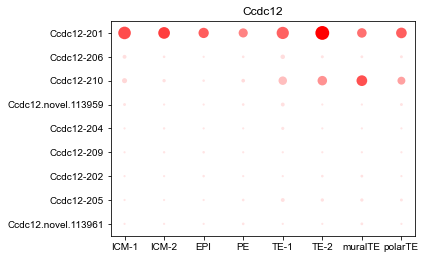

Ccdc42


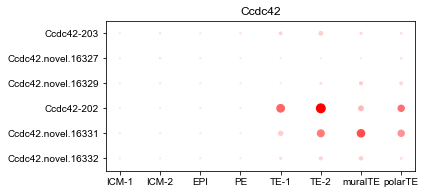

Cdk2ap1


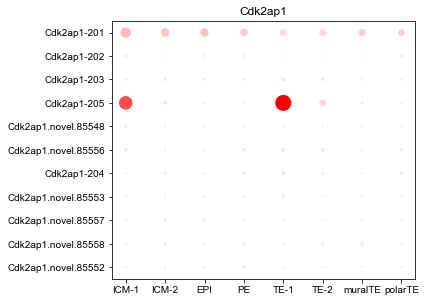

Cndp2


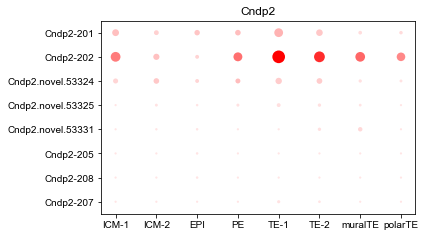

Crb3


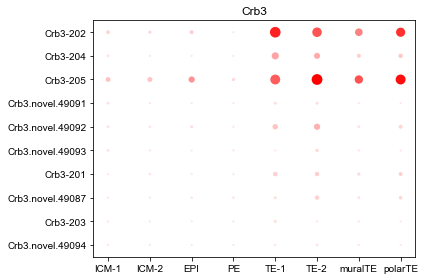

Folr1


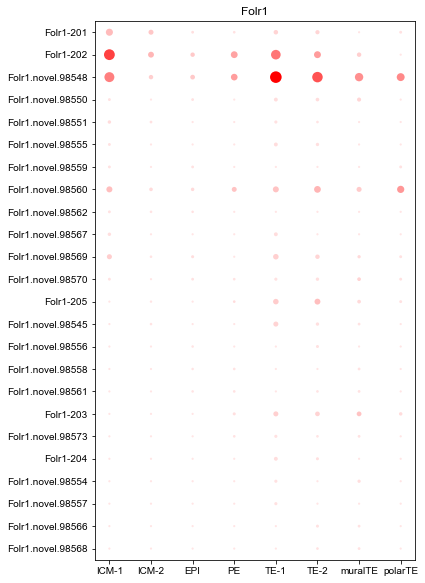

H3f3b


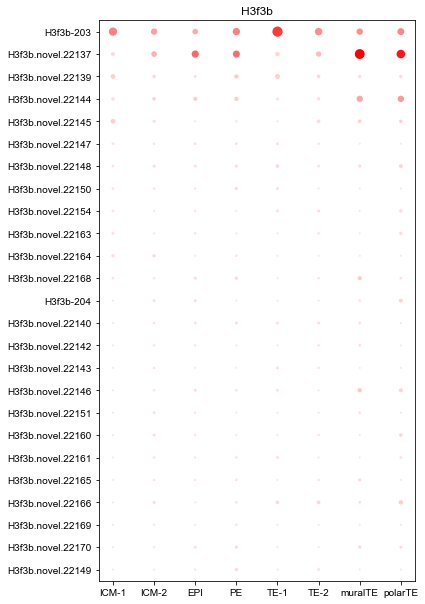

Lmna


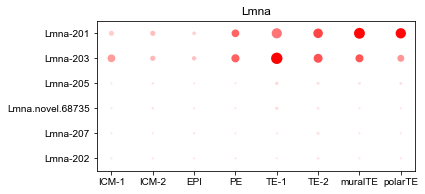

Pdlim7


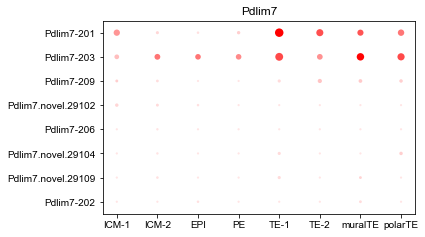

Pemt


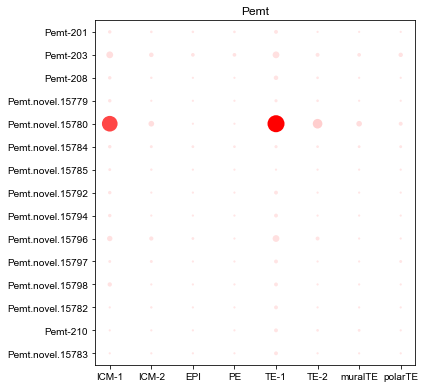

Prrc1


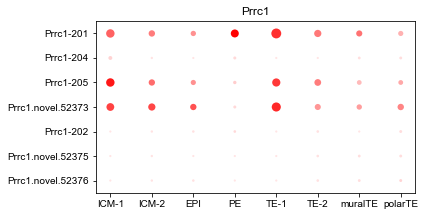

Pstk


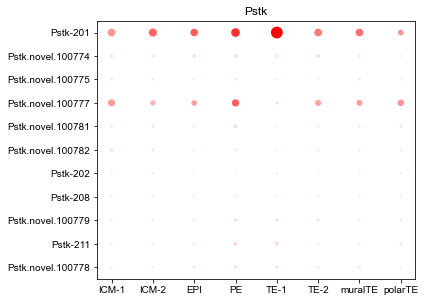

Rpl41


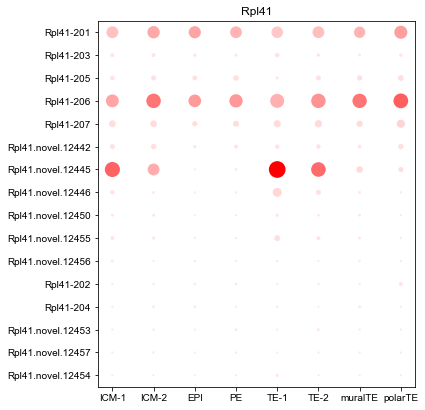

Rpl9


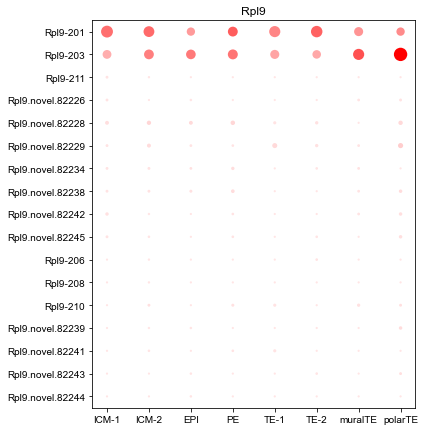

Snhg5


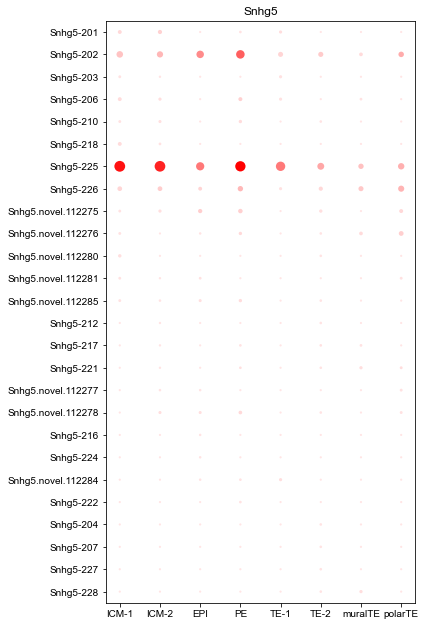

Snrpc


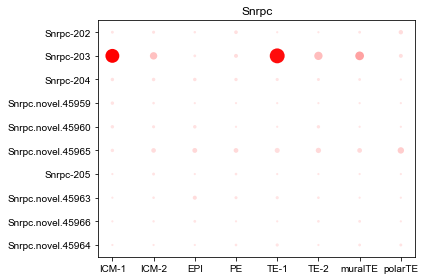

Srebf2


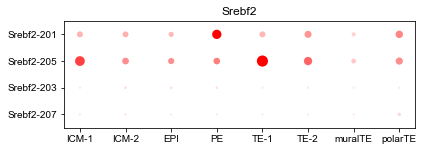

Tpm1


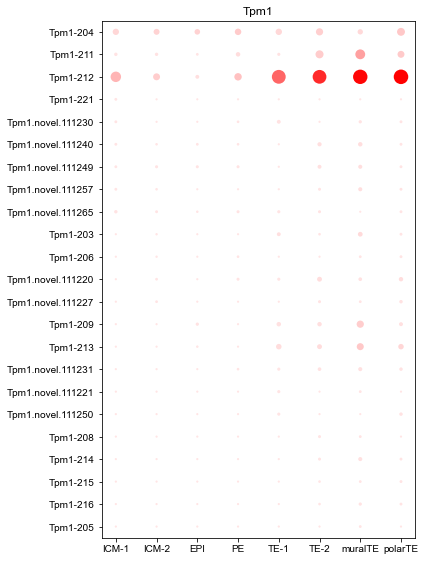

Ugp2


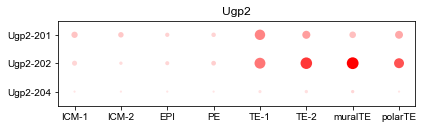

Vma21


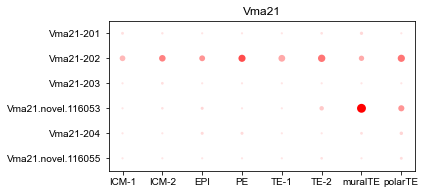

In [6]:
params = dict()

for gene in isoform_specific_genes:
    print(gene, sep="\t")
    d = data[gene]
    tids = list(d.index)    
    
    array_1 = []
    array_2 = []
    for ct in cts:
        matrix = data_matrix[ct].loc[tids]
        s = (matrix > 0).sum(axis=1) / len(matrix.columns)
        s.name = ct
        array_1.append(s)
        
        s = (matrix.sum(axis=1) / (matrix > 0).sum(axis=1)).fillna(0)
        s.name = ct
        array_2.append(s)
        
    m1 = pd.concat(array_1, axis=1) # Percentage of expressed cells
    # m1 = m1 / m1.max().max()
    
    # m2 = pd.concat(array_2, axis=1) # average expression level
    # m2 = m2 / m2.max().max()
    
    m2 = d[["TPM.%s" % ct for ct in cts]].fillna(0) # TPM
    m2 = m2 / m2.max().max() # TPM
    
    params[gene] = [m1, m2]
    
    plt.figure(figsize=(6, 1 + len(tids) * 0.3))
    plt.title(gene)
    matrix1 = m1.values
    matrix2 = m2.values
    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):
            v1 = matrix1[i][j]
            s = v1 * 300 + 5
            v2 = matrix2[i][j]
            a = v2 * 0.9 + 0.1
            plt.scatter([j], [i], color="red", edgecolor="none", alpha=a, s=s)
    plt.xticks(np.arange(len(cts)), cts)
    plt.yticks(np.arange(len(tids)), tids)
    plt.ylim(len(matrix1) - 0.5, -0.5)
    plt.tight_layout()
    plt.show()

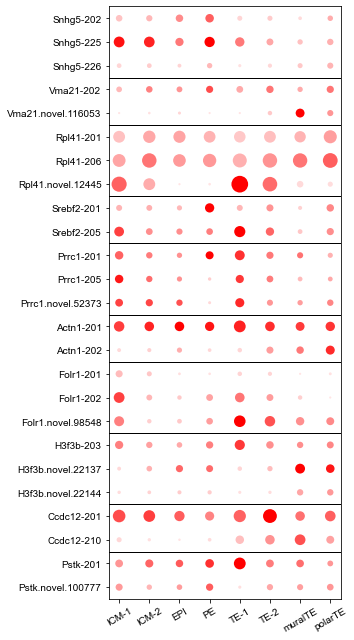

In [7]:
tids_selected = [
    "Snhg5-202", "Snhg5-225", "Snhg5-226",
    "Vma21-202", "Vma21.novel.116053",
    "Rpl41-201", "Rpl41-206", "Rpl41.novel.12445",
    "Srebf2-201", "Srebf2-205",
    "Prrc1-201", "Prrc1-205", "Prrc1.novel.52373",
    "Actn1-201", "Actn1-202",
    "Folr1-201", "Folr1-202", "Folr1.novel.98548",
    "H3f3b-203", "H3f3b.novel.22137", "H3f3b.novel.22144",
    "Ccdc12-201", "Ccdc12-210",
    "Pstk-201", "Pstk.novel.100777",
    # "Pdgfa-201", "Pdgfa-202"  
]

array1 = []
array2 = []
for tname in tids_selected:
    if "novel" in tname:
        gname = tname.split("novel")[0][:-1]
    else:
        gname = tname[:-4]
    m1, m2 = params[gname]
    m1 = m1[[x == tname for x in m1.index]]
    m2 = m2[[x == tname for x in m2.index]]
    array1.append(m1)
    array2.append(m2)
m1 = pd.concat(array1, axis=0)
m2 = pd.concat(array2, axis=0)

plt.figure(figsize=(5, 9))
matrix1 = m1.values
matrix2 = m2.values
for i in range(len(matrix1)):
    for j in range(len(matrix1[0])):
        v1 = matrix1[i][j]
        s = v1 * 300 + 5
        v2 = matrix2[i][j]
        a = v2 * 0.9 + 0.1
        plt.scatter([j], [i], color="red", edgecolor="none", alpha=a, s=s)
plt.xticks(np.arange(len(m1.columns)), m1.columns, rotation=30)
plt.yticks(np.arange(len(m1.index)), m1.index)
plt.ylim(len(matrix1) - 0.5, -0.5)

ys = [2, 4, 7, 9, 12, 14, 17, 20, 22]
for y in ys:
    plt.axhline(y + 0.5, lw=1, color="black")
plt.tight_layout()
plt.savefig("figures/celltype_specific_isoforms.pdf", dpi=300)

# Plot bar

--------------------------------------------------------------------------------
Rpl41
['Rpl41-201', 'Rpl41-206', 'Rpl41.novel.12445']
--------------------------------------------------------------------------------
Vma21
['Vma21-202', 'Vma21.novel.116053']
--------------------------------------------------------------------------------
Prrc1
['Prrc1-201', 'Prrc1.novel.52373']


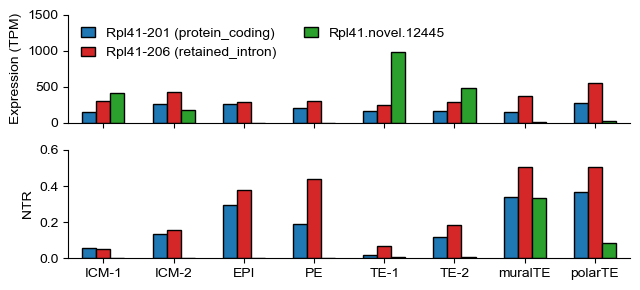

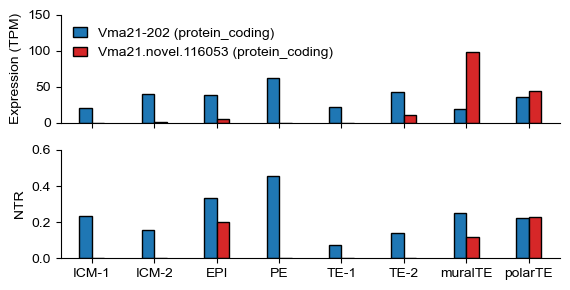

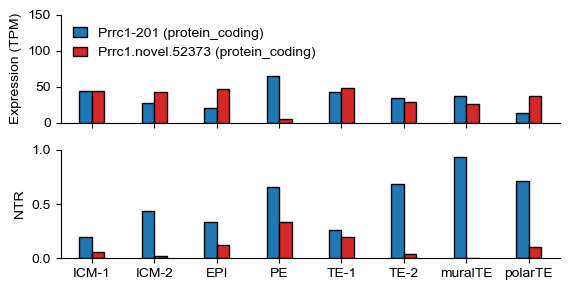

In [14]:
def plot_bar(gname, tids, labels, ylim1, ylim2, figsize, show_pval):
    print("-" * 80)
    print(gname)
    print(tids)
    
    d = data[gname].loc[tids]
    d1 = d[["Total.%s" % ct for ct in cts]].fillna(0)
    d2 = d[["TPM.%s" % ct for ct in cts]].fillna(0)
    d3 = d[["NTR.%s" % ct for ct in cts]].fillna(0)
    d4 = d[["Nascent.%s" % ct for ct in cts]].fillna(0)
    
    n = len(tids)
    w = 0.2
    colors = ["C0", "C3", "C2"]

    xs = np.arange(len(cts))

    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)
    plt.sca(axs[0])
    for i, tid in enumerate(tids):
        ys1 = d2.loc[tid]
        xs1 = xs + (i + 0.5 - 0.5 * n) * w
        plt.bar(xs1, ys1, width=w, color=colors[i], edgecolor="black", label=labels[i])
    plt.ylim(0, ylim1)
    plt.ylabel("Expression (TPM)")
    plt.legend(handlelength=1, frameon=False, ncol=1 if n == 2 else 2, loc="upper left", bbox_to_anchor=(0, 1))
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.sca(axs[1])
    for i, tid in enumerate(tids):
        ys1 = d3.loc[tid]
        xs1 = xs + (i + 0.5 - 0.5 * n) * w
        plt.bar(xs1, ys1, width=w, color=colors[i], edgecolor="black", label=labels[i])
    if show_pval:
        for i, ct in enumerate(cts):
            ntr1, ntr2 = d3["NTR.%s" % ct].values
            total1, total2 = d1["Total.%s" % ct].values
            nascent1, nascent2 = d4["Nascent.%s" % ct].values
            pval = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
            print(ct, total1, nascent1, total2, nascent2, pval, sep="\t")
            if min(total1, total2) >= 10:
                y1 = max(ntr1, ntr2) + ylim2 * 0.1
                y2 = max(ntr1, ntr2) + ylim2 * 0.05
                fontsize = 18
                if pval < 0.001:
                    text = "***"
                elif pval < 0.01:
                    text = "**"
                elif pval < 0.05:
                    text = "*"
                else:
                    text = "NS"
                    fontsize = 10
                    y2 = max(ntr1, ntr2) + ylim2 * 0.15
                plt.plot([i - 0.2, i + 0.2], [y1, y1], color="black", lw=1)
                plt.text(i, y2, text, ha="center", va="bottom", size=fontsize)
    plt.xticks(xs, cts, rotation=0)
    plt.ylim(0, ylim2)
    plt.ylabel("NTR")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.tight_layout()
    plt.savefig("figures/isoform_halflife_diversity.%s.pdf" % gname, dpi=300)

gname = "Rpl41"
tids = ["Rpl41-201", "Rpl41-206", "Rpl41.novel.12445"]
labels = ["Rpl41-201 (protein_coding)", "Rpl41-206 (retained_intron)", "Rpl41.novel.12445"]
ylim1 = 1500
ylim2 = 0.6
plot_bar(gname, tids, labels, ylim1, ylim2, figsize=(6.5, 3), show_pval=False)

gname = "Vma21"
tids = ["Vma21-202", "Vma21.novel.116053"]
labels = ["Vma21-202 (protein_coding)", "Vma21.novel.116053 (protein_coding)"]
ylim1 = 150
ylim2 = 0.6
plot_bar(gname, tids, labels, ylim1, ylim2, figsize=(5.8, 3), show_pval=False)

gname = "Prrc1"
tids = ["Prrc1-201", "Prrc1.novel.52373"]
labels = ["Prrc1-201 (protein_coding)", "Prrc1.novel.52373 (protein_coding)"]
ylim1 = 150
ylim2 = 1
plot_bar(gname, tids, labels, ylim1, ylim2, figsize=(5.8, 3), show_pval=False)

# Plot tracks

In [2]:
f_gtf = "../../1_FLAIRseq/results/assembly_custom/gtf/MouseBlastocyst.all.gtf.gz"
with GtfFile(f_gtf) as f:
    records = [x for x in f]
transcripts = dict()
for t in GtfTranscriptBuilder(records):
    name = t.name
    try:
        name = t.records["transcript"][0].attributes["transcript_name"]
    except Exception:
        pass
    transcripts[name] = t

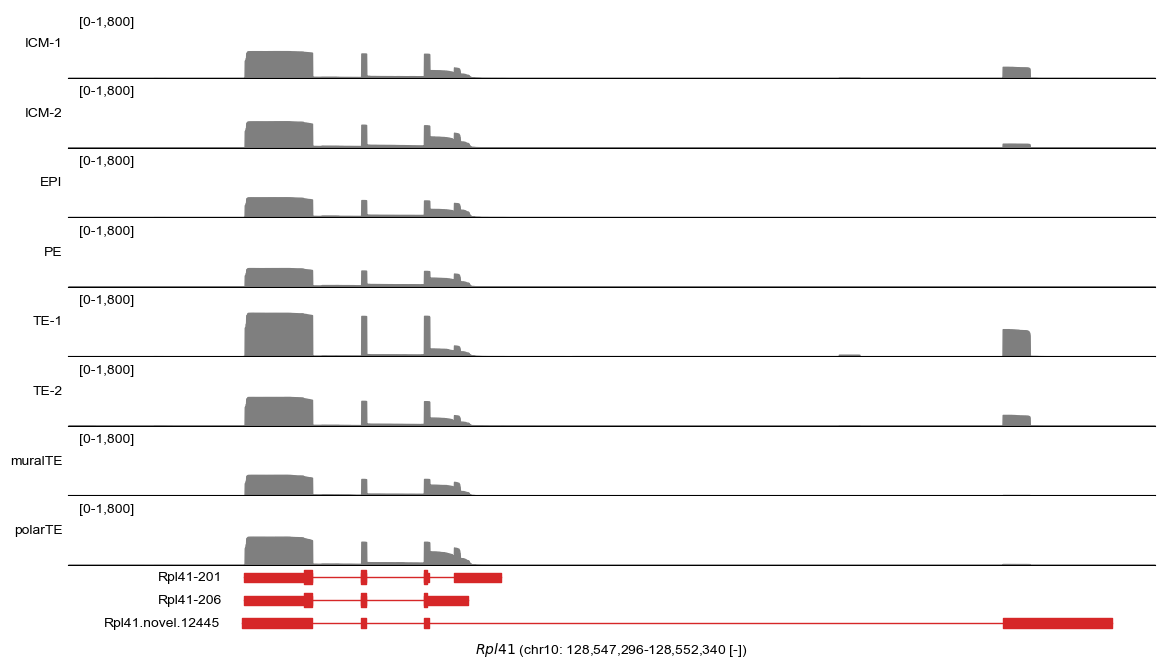

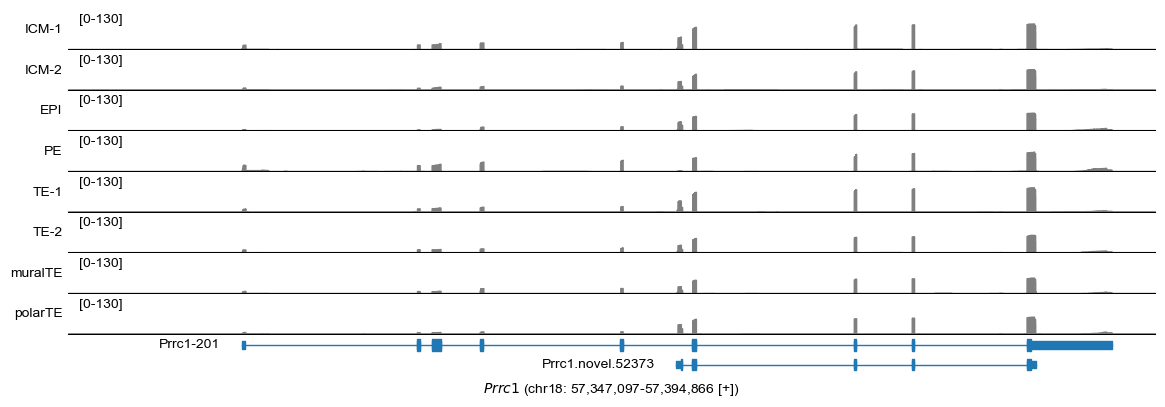

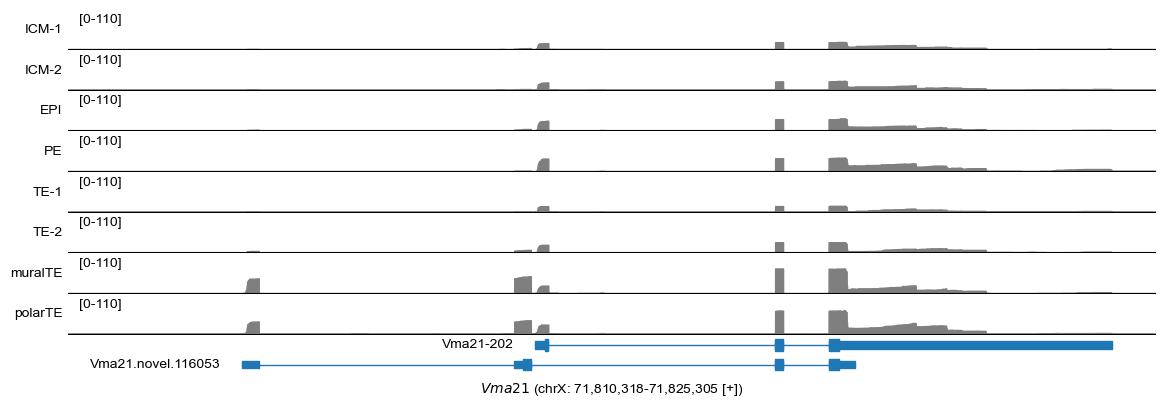

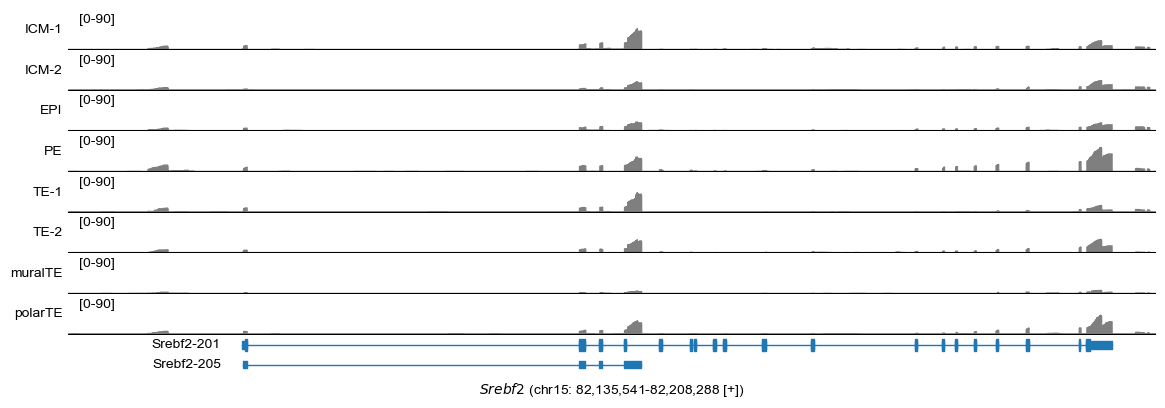

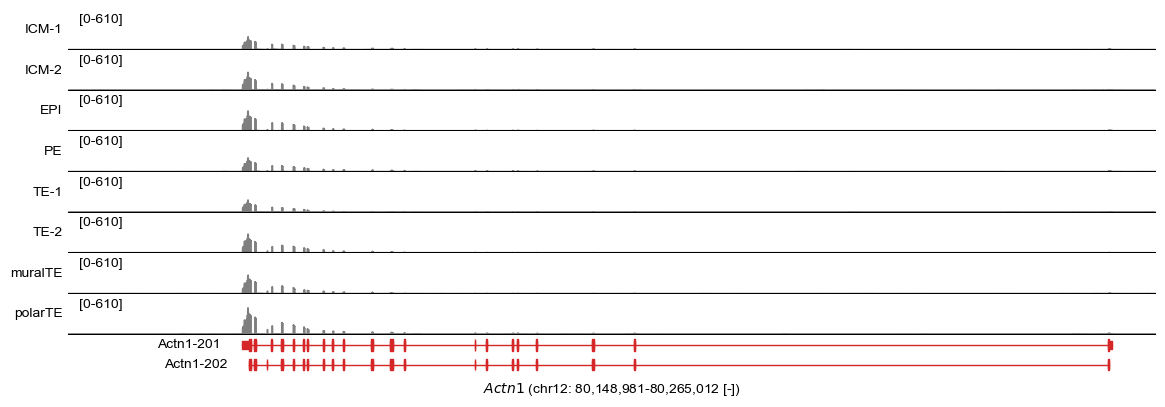

In [3]:
cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]

def get_coverage(celltype, chrom, start, end):
    import pyBigWig
    path = "results/cell_type_specific_bams/%s.bw" % celltype
    bw = pyBigWig.open(path)
    covs = np.nan_to_num(bw.values(chrom, start, end), 0)
    bw.close()

    path = "results/cell_type_specific_bams/%s.flagstat" % celltype
    for line in open(path):
        size = int(line.strip().split()[0])
        break
    covs = covs * 1000000 / size
    return covs

def plot_tracks(gname, tids, tnames, figsize, ystep):
    ts = []
    for tid in tids:
        t = transcripts[tid]
        ts.append(t)

    chrom = ts[0].chrom
    start = min([t.start for t in ts])
    end = max([t.end for t in ts])
    strand = ts[0].strand
    length = end - start
    if True: # extend
        start = start - int(length * 0.20)
        end = end + int(length * 0.05)
        length = end - start

    w, h = figsize
    fig, axs = plt.subplots(9, 1, 
                            figsize=figsize, 
                            gridspec_kw=dict(wspace=0, hspace=0.1/h, left=0.6/w, right=1-0.13/w, bottom=0.25/h, top=1-0.1/h),
                           )

    ylims = []
    for i, ct in enumerate(cts):
        plt.sca(axs[i])
        ys = get_coverage(ct, chrom, start, end)
        xs = np.arange(start, end)
        plt.fill_between(xs, 0, ys, color="C7")
        plt.xlim(start, end)
        plt.xticks([])
        # ylim = int(max(ys) * 1.5)
        ylim = (int(max(ys) * 1.5 / ystep) + 1) * ystep
        ylims.append(ylim)
        plt.yticks([])
        plt.ylabel(ct, rotation=0, ha="right", va="center")
    ylim = max(ylims)
    for i, ct in enumerate(cts):
        plt.sca(axs[i])
        plt.ylim(0, ylim)
        plt.text(start + length * 0.01, ylim * 0.9, "[0-%s]" % format(ylim, ','), va="top")
    thick1 = 0.4 # exon
    thick2 = 0.6 # CDS
    color = "C0" if strand == "+" else "C3"
    ax = axs[-1]
    plt.sca(ax)
    for i, t in enumerate(ts):
        plt.plot([t.start, t.end], [i + 0.5, i + 0.5], color=color, lw=1)
        plt.text(t.start - length * 0.02, i + 0.5, tnames[i], ha="right", va="center")
        for block in t.blocks:
            plt.fill_between([block[0], block[1]], 
                             [i + 0.5 - thick1 / 2, i + 0.5 - thick1 / 2], 
                             [i + 0.5 + thick1 / 2, i + 0.5 + thick1 / 2], lw=1, color=color, zorder=10)
        if t.thick:
            for block in t.blocks:
                x1, x2 = max(block[0], t.thick[0]), min(block[1], t.thick[1])
                if x1 >= x2:
                    continue
                plt.fill_between([x1, x2], 
                                 [i + 0.5 - thick2 / 2, i + 0.5 - thick2 / 2], 
                                 [i + 0.5 + thick2 / 2, i + 0.5 + thick2 / 2], lw=1, color=color, zorder=10)
    plt.xlim(start, end)
    plt.xticks([])
    plt.ylim(len(ts), 0)
    plt.yticks([])
    plt.xlabel("$\it{%s}$ (%s: %s-%s [%s])" % (gname, chrom, format(start, ","), format(end, ","), strand))

    for i, ax in enumerate(axs):
        ax.spines["top"].set_visible(False)
        if i == len(axs) - 1:
            ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
    
    plt.savefig("figures/isoform_coverage_track.%s.pdf" % gname)
    
gname = "Rpl41"
tids = ["Rpl41-201", "Rpl41-206", "Merged.12445"]
tnames = [ "Rpl41-201", "Rpl41-206", "Rpl41.novel.12445"]
# plot_tracks(gname, tids, tnames, figsize=(6.5, 6.6), ystep=100)
plot_tracks(gname, tids, tnames, figsize=(11.6, 6.6), ystep=100)

gname = "Prrc1"
tids = ["Prrc1-201", "Merged.52373"]
tnames = ["Prrc1-201", "Prrc1.novel.52373"]
plot_tracks(gname, tids, tnames, figsize=(11.6, 4), ystep=10)

gname = "Vma21"
tids = ["Vma21-202", "Merged.116053"]
tnames = ["Vma21-202", "Vma21.novel.116053"]
plot_tracks(gname, tids, tnames, figsize=(11.6, 4), ystep=10)

gname = "Srebf2"
tids = ["Srebf2-201", "Srebf2-205"]
tnames = ["Srebf2-201", "Srebf2-205"]
plot_tracks(gname, tids, tnames, figsize=(11.6, 4), ystep=10)

gname = "Actn1"
tids = ["Actn1-201", "Actn1-202"]
tnames = ["Actn1-201", "Actn1-202"]
plot_tracks(gname, tids, tnames, figsize=(11.6, 4), ystep=10)

# Amino acid of isoform

In [3]:
f_gtf = "../../1_NanoNASCseq/results/assembly/custom_merge/gtf/MouseBlastocyst.all.gtf.gz"
with GtfFile(f_gtf) as f:
    records = [x for x in f]
transcripts = list(GtfTranscriptBuilder(records))

In [8]:
tname2transcript = dict()
for t in transcripts:
    record = t.records["transcript"][0]
    tname = record.attributes.get("transcript_name", t.name)
    tname2transcript[tname] = t

In [28]:
from Bio.Seq import Seq

f_fasta = "/home/chenzonggui/species/mus_musculus/GRCm38.p6/GRCm38.canonical.genome.fa"
with FastaFile(f_fasta) as fasta:
    for tname in ["Prrc1-201", "Merged.52373", "Vma21-202", "Merged.116053"]:
        print("-" * 80)
        print("Transcript name:", tname)
        t = tname2transcript[tname]
        i1, i2, i3, i4 = t.indexes()
        seq = fasta.fetch(obj=t)
        cds = seq[i2:i3]
        print("CDS length:", len(cds))
        print("CDS sequence:", cds)
        aa = Seq(cds).translate().strip("*")
        print("Amoni acids length:", len(aa))
        print("Amino acids:", aa)

--------------------------------------------------------------------------------
Transcript name: Prrc1-201
CDS length: 1329
CDS sequence: ATGATGGAAGAAAGTGGAATCGAGACCACGCCGCCTGGAACCCCTCCCCTGCATCCTGCAGGCTTGGCTGCCGTGCCCTCCACTGAAGCTCACTCAGCTGCAACCAGTTCCTTCTCGTCTCCCAACGTGTCGGGAATGGAGTCTCTGCCCCCACACGTGTATTCCACGCCTCAGCCCTCCCTGCCCCCTGTGCAGCCGTCCGCGCCACCTCCCTTTGTGTCGATGTCTCCGGCTCCTTCCGTTCCCCTGAGTGGCACTTCTGTGCCGCCCTCCGTGTCTCCATCGCCTGCCACTGCCTTCAGCGGCCCTCCGATGTCCCACTTCCCGCCTGCGACCTCTGCCTCGGGTGCTCTCCTGTCTGCACCGCCTTCAGGGCCTCCGATATCAGGGTTTTCTGTCGGTACAACCTACGACATCACGAGGGGACATGCTGGGAGGGCGCCCCAGACACCTCTGATGCCGTCATTTTCTGCACCTCCGGTTACAGGTATCTTGCCAGCCCCCATTACTCAGCAAGCCAGCATGACGTCTCTGGCCCAGGGACCTGGAACCACATCAGCCATTACTTTCCCGGAGGAACAGGAAGATCCCAGAATTAACAGAGGCCAGGATGATGCCCCTGCTGGCGGGATCTGGGGTTTTATTAAGGGCGTAGCTGGGAACCCTATGGTGAAATCTGTCCTGGATAAGACCAAGCATTCTGTAGAAAGCATGATCACCACGCTGGATCCTGGCATGGCTCCATATATCAAATCTGGAGGTGAACTGGATATTGTCGTAACCTCAAATAAAGAAGTGAAAGTGGCTGCTGTCCGAGATGCCTTCCAGGAGGTCTTTGGCTTAGCTGTGGTTGTTGGGGAA